In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

fatal: destination path 'colab-biolab' already exists and is not an empty directory.
./
./root/
./root/.condarc
./root/.vimrc
./root/.bashrc.biolab
./root/.bin.priority/
./root/.bin.priority/pip2
./root/.bin.priority/pip
./root/.bin.priority/pip3
./root/.tmux.conf
./root/.profile
PREFIX=/root/conda
Unpacking payload ...
entry_point.py:256: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
entry_point.py:256: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
entry_point.py:256: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to contr

In [3]:
!conda install -y bedtools bioawk samtools

Channels:
 - conda-forge
 - bioconda
 - defaults
Platform: linux-64
Solving environment: \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 25.3.1
    latest version: 25.5.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /root/conda

  added / updated specs:
    - bedtools
    - bioawk
    - samtools


The following packages will be UPDATED:

  ca-certificates    pkgs/main/linux-64::ca-certificates-2~ --> conda-forge/noarch::ca-certificates-2025.4.26-hbd8a1cb_0 
  conda              pkgs/main::conda-25.3.1-py313h06a4308~ --> conda-forge::conda-25.5.0-py313h78bf25f_0 
  openssl              pkgs/main::openssl-3.0.16-h5eee18b_0 --> conda-forge::openssl-3.5.0-h7b32b05_1 




Preparing transaction: - done
Verifying transaction: | / - \ | done
Executing transaction: - done


In [4]:
%cd /content/drive/MyDrive/binfo1-work/

/content/drive/MyDrive/binfo1-work


In [5]:
!grep -i mirlet7g ../binfo1-datapack1/gencode.gtf

chr9	ENSEMBL	gene	106056039	106056126	.	+	.	gene_id "ENSMUSG00000065440.3"; gene_type "miRNA"; gene_name "Mirlet7g"; level 3; mgi_id "MGI:2676800";
chr9	ENSEMBL	transcript	106056039	106056126	.	+	.	gene_id "ENSMUSG00000065440.3"; transcript_id "ENSMUST00000083506.3"; gene_type "miRNA"; gene_name "Mirlet7g"; transcript_type "miRNA"; transcript_name "Mirlet7g-201"; level 3; transcript_support_level "NA"; mgi_id "MGI:2676800"; tag "basic";
chr9	ENSEMBL	exon	106056039	106056126	.	+	.	gene_id "ENSMUSG00000065440.3"; transcript_id "ENSMUST00000083506.3"; gene_type "miRNA"; gene_name "Mirlet7g"; transcript_type "miRNA"; transcript_name "Mirlet7g-201"; exon_number 1; exon_id "ENSMUSE00000522665.2"; level 3; transcript_support_level "NA"; mgi_id "MGI:2676800"; tag "basic";


In [44]:
#수정
import requests

def get_kegg_pathways(LIN28A):
    # Search for the gene symbol in KEGG
    url = f"http://rest.kegg.jp/find/genes/{LIN28A}"
    response = requests.get(url)

    if response.status_code == 200:
        entries = response.text.strip().split('\n')
        for entry in entries:
            gene_id = entry.split('\t')[0]
            pathways_url = f"http://rest.kegg.jp/link/pathway/{gene_id}"
            pathways_response = requests.get(pathways_url)

            if pathways_response.status_code == 200:
                result = pathways_response.text.strip()
                if result:
                    print(f"\nPathways for {gene_id}:")
                    for line in result.split('\n'):
                        print("  ", line)
                else:
                    print(f"\nNo pathways found for {gene_id}")
            else:
                print(f"\nFailed to retrieve pathways for {gene_id}")
    else:
        print(f"Gene {LIN28A} not found in KEGG.")

get_kegg_pathways("LIN28A")


KeyboardInterrupt: 

In [27]:
import requests
import pandas as pd

def get_string_interactions(gene_name, species=9606, required_score=700, limit=20):
    """
    Fetch interaction partners from STRING database using STRING API.
    - gene_name: name of the gene (e.g., 'LIN28A')
    - species: NCBI taxonomy ID (9606 = human)
    - required_score: minimum confidence score (0–1000)
    - limit: max number of interactions returned
    """

    url = "https://string-db.org/api/tsv/network"

    params = {
        "identifiers": gene_name,
        "species": species,
        "required_score": required_score,
        "limit": limit,
        "caller_identity": "chatgpt_string_example"
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        lines = response.text.strip().split("\n")
        data = [line.split("\t") for line in lines[1:]]  # Skip header
        df = pd.DataFrame(data, columns=lines[0].split("\t"))
        return df
    else:
        print("Failed to fetch STRING data.")
        return None

df = get_string_interactions("LIN28A", required_score=700, limit=50)

if df is not None:
    print(df[["preferredName_A", "preferredName_B", "score"]])


    preferredName_A preferredName_B  score
0             SALL4         ZSCAN10  0.869
1             SALL4           STAT3   0.88
2             SALL4          LIN28A  0.905
3             SALL4          PRDM14  0.908
4             SALL4            SOX2  0.983
..              ...             ...    ...
124           GAPDH             MYC   0.85
125           KHSRP          DICER1  0.979
126           KHSRP          DROSHA  0.985
127          DROSHA          DICER1  0.992
128           HMGA2             MYC  0.756

[129 rows x 3 columns]


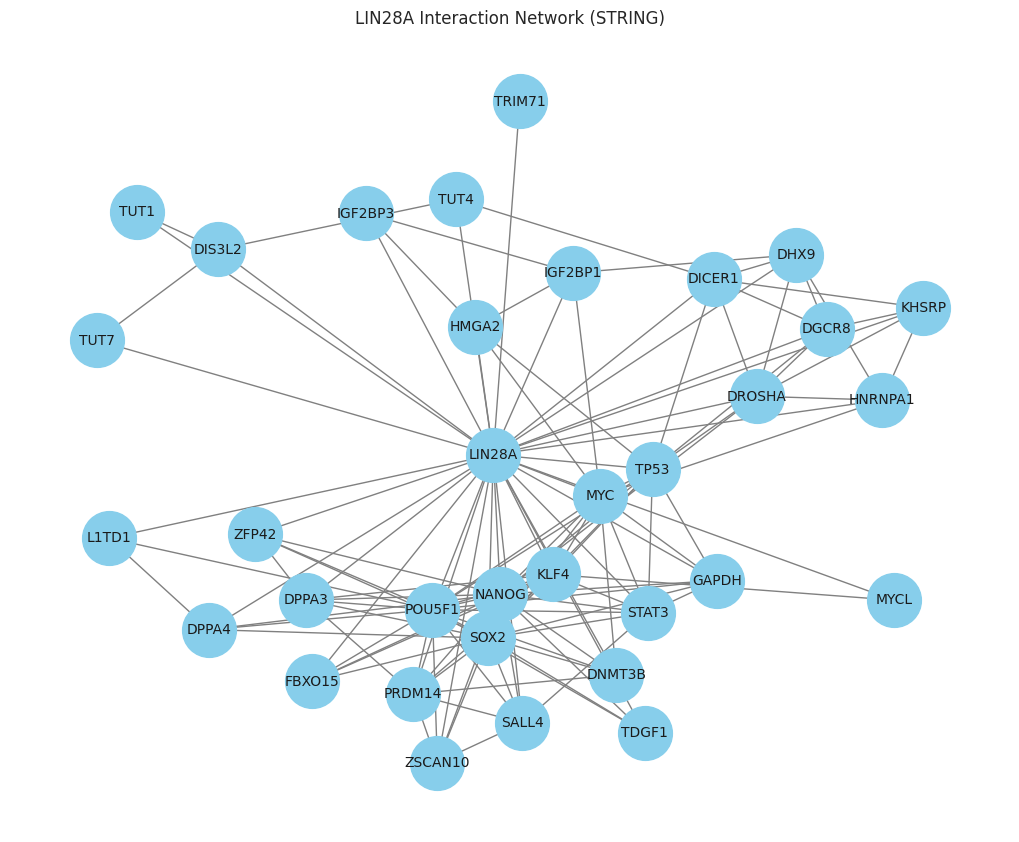

In [28]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row["preferredName_A"], row["preferredName_B"], weight=float(row["score"]))

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=1500, font_size=10)
plt.title("LIN28A Interaction Network (STRING)")
plt.show()


Number of nodes: 34
Number of edges: 129
Top 5 nodes by degree centrality:
LIN28A: 1.000
POU5F1: 0.545
NANOG: 0.545
SOX2: 0.515
TP53: 0.364
Average clustering coefficient: 0.733
Detected 3 communities at 2nd split:
Community 1: ['POU5F1', 'SOX2', 'L1TD1', 'PRDM14', 'MYC', 'IGF2BP1', 'DPPA3', 'ZFP42', 'TDGF1', 'DPPA4', 'SALL4', 'TP53', 'KHSRP', 'KLF4', 'ZSCAN10', 'DHX9', 'IGF2BP3', 'NANOG', 'HMGA2', 'HNRNPA1', 'DROSHA', 'FBXO15', 'GAPDH', 'LIN28A', 'DGCR8', 'DNMT3B', 'DICER1', 'STAT3', 'MYCL']
Community 2: ['TUT4', 'DIS3L2', 'TUT1', 'TUT7']
Community 3: ['TRIM71']


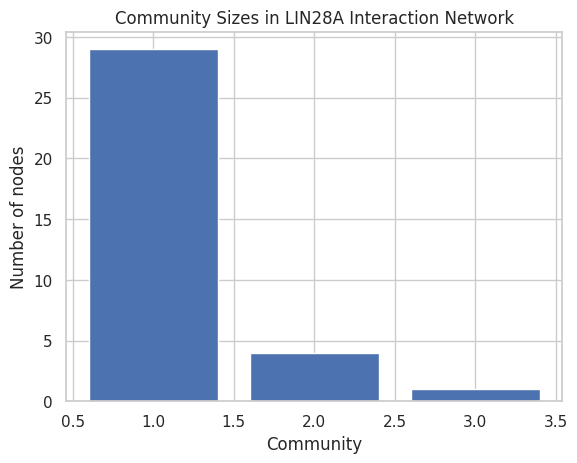

In [29]:
import networkx as nx

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# degree centrality
degree_centrality = nx.degree_centrality(G)
top5 = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by degree centrality:")
for node, cent in top5:
    print(f"{node}: {cent:.3f}")

clustering_coeff = nx.average_clustering(G)
print(f"Average clustering coefficient: {clustering_coeff:.3f}")

# Girvan-Newman 알고리즘,
from networkx.algorithms.community import girvan_newman
communities = girvan_newman(G)
limited = next(communities)
limited = next(communities)

print(f"Detected {len(limited)} communities at 2nd split:")
for i, comm in enumerate(limited):
    print(f"Community {i+1}: {list(comm)}")

# Visualization
import matplotlib.pyplot as plt

comm_sizes = [len(c) for c in limited]
plt.bar(range(1, len(comm_sizes)+1), comm_sizes)
plt.xlabel("Community")
plt.ylabel("Number of nodes")
plt.title("Community Sizes in LIN28A Interaction Network")
plt.show()


In [31]:
community_genes = [list(c) for c in limited]

go_results = []

for i, genes in enumerate(community_genes, start=1):
    print(f"\n🧬 Analyzing Community {i} with {len(genes)} genes...")

    # gseapy enrichr (Mouse gene symbol 기준)
    enr = gp.enrichr(
    gene_list=genes,
    gene_sets=['GO_Biological_Process_2021'],
    organism='Mouse',
    outdir=None,
    cutoff=0.05
)


    if enr.results.empty:
        print("No significant GO terms found for this community.")
    else:
        print(enr.results[['Term', 'Adjusted P-value']].head(5))

    go_results.append(enr.results)



🧬 Analyzing Community 1 with 29 genes...
                                                Term  Adjusted P-value
0  regulation of macromolecule metabolic process ...      4.471641e-09
1         regulation of gene expression (GO:0010468)      1.442269e-08
2               miRNA metabolic process (GO:0010586)      1.442269e-08
3  regulation of transcription by RNA polymerase ...      1.202122e-06
4  cellular response to cytokine stimulus (GO:007...      2.112212e-06

🧬 Analyzing Community 2 with 4 genes...
                                                Term  Adjusted P-value
0  modification-dependent macromolecule catabolic...      1.223586e-08
1        histone mRNA catabolic process (GO:0071044)      2.319343e-08
2               miRNA metabolic process (GO:0010586)      3.873408e-08
3  nuclear-transcribed mRNA catabolic process (GO...      4.385255e-08
4        histone mRNA metabolic process (GO:0008334)      6.676692e-08

🧬 Analyzing Community 3 with 1 genes...
                        

In [32]:
top_genes = [gene for gene, cent in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20]]
print("Top 20 hub genes:", top_genes)


Top 20 hub genes: ['LIN28A', 'POU5F1', 'NANOG', 'SOX2', 'TP53', 'MYC', 'KLF4', 'STAT3', 'PRDM14', 'DROSHA', 'SALL4', 'GAPDH', 'DPPA3', 'DICER1', 'ZSCAN10', 'DNMT3B', 'DGCR8', 'DHX9', 'DPPA4', 'FBXO15']


In [35]:
# BAM 파일들 (Ribo-seq, RNA-seq)
bam_files = {
    'RNA_siLuc': '/content/drive/MyDrive/binfo1-datapack1/RNA-siLuc.bam',
    'RNA_siLin28a': '/content/drive/MyDrive/binfo1-datapack1/RNA-siLin28a.bam',
    'RPF_siLuc': '/content/drive/MyDrive/binfo1-datapack1/RPF-siLuc.bam',
    'RPF_siLin28a': '/content/drive/MyDrive/binfo1-datapack1/RPF-siLin28a.bam'
}

gtf_file = '/content/drive/MyDrive/binfo1-datapack1/gencode.gtf'

lin28a_peak_bed = '/content/drive/MyDrive/binfo1-datapack1/LIN28A_peaks.bed'

In [36]:
import pandas as pd

def parse_gtf(gtf_path):
    gene_exons = {}
    with open(gtf_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            cols = line.strip().split('\t')
            if cols[2] == 'exon':
                chrom = cols[0]
                start = int(cols[3]) - 1  # 0-based coordinate
                end = int(cols[4])
                attr = cols[8]
                gene_id = None
                for attr_part in attr.split(';'):
                    if 'gene_id' in attr_part:
                        gene_id = attr_part.strip().split(' ')[1].replace('"', '')
                        break
                if gene_id is None:
                    continue
                if gene_id not in gene_exons:
                    gene_exons[gene_id] = []
                gene_exons[gene_id].append((chrom, start, end))
    return gene_exons

gene_exons = parse_gtf(gtf_file)
print(f"Parsed {len(gene_exons)} genes from GTF.")


Parsed 55359 genes from GTF.


In [45]:
import pysam
import time

def count_reads_for_sample(sample_name, bam_path, gene_exons):
    bam = pysam.AlignmentFile(bam_path, "rb")
    gene_counts = {}
    total_genes = len(gene_exons)
    start_time = time.time()

    for i, (gene_id, exons) in enumerate(gene_exons.items()):
        count = 0
        for chrom, start, end in exons:
            try:
                count += bam.count(contig=chrom, start=start, end=end)
            except ValueError:
                pass
        gene_counts[gene_id] = count

        if i % 1000 == 0:
            elapsed = time.time() - start_time
            print(f"{sample_name}: Processed {i}/{total_genes} genes - {elapsed:.1f}s elapsed")

    bam.close()
    print(f"✅ {sample_name} counting done.")
    return gene_counts


In [41]:
print(bam_files)

{'RNA_siLuc': '/content/drive/MyDrive/binfo1-datapack1/RNA-siLuc.bam', 'RNA_siLin28a': '/content/drive/MyDrive/binfo1-datapack1/RNA-siLin28a.bam', 'RPF_siLuc': '/content/drive/MyDrive/binfo1-datapack1/RPF-siLuc.bam', 'RPF_siLin28a': '/content/drive/MyDrive/binfo1-datapack1/RPF-siLin28a.bam'}


In [46]:
#시간 여유 두고 돌리기
sample = 'RNA_siLuc'
bam_path = bam_files[sample]

counts_sample = count_reads_for_sample(sample, bam_path, gene_exons)
print(f"Number of genes counted for {sample}: {len(counts_sample)}")
print(list(counts_sample.items())[:5])

RNA_siLuc: Processed 0/55359 genes - 0.0s elapsed


KeyboardInterrupt: 

In [ ]:
#1주차
import requests

def get_kegg_pathways_for_gene(gene_symbol, species="mmu"):
    """Return KEGG pathways for a single gene (e.g., LIN28A)"""
    find_url = f"http://rest.kegg.jp/find/genes/{species}:{gene_symbol}"
    find_response = requests.get(find_url)

    if find_response.status_code == 200 and find_response.text:
        gene_id = find_response.text.split("\t")[0]  # e.g., hsa:84621
        link_url = f"http://rest.kegg.jp/link/pathway/{gene_id}"
        link_response = requests.get(link_url)
        if link_response.status_code == 200:
            return [line.split("\t")[1] for line in link_response.text.strip().split("\n")]
    return []

kegg_map = {}
interactors = set(df["preferredName_A"]).union(set(df["preferredName_B"]))

for gene in interactors:
    kegg_pathways = get_kegg_pathways_for_gene(gene)
    kegg_map[gene] = kegg_pathways

for gene, pathways in kegg_map.items():
    print(f"{gene}: {pathways}")


IGF2BP1: []
DIS3L2: []
KHSRP: []
TUT1: []
ZFP42: []
MYC: []
DGCR8: []
HNRNPA1: []
MYCL: []
DROSHA: []
TDGF1: []
POU5F1: []
SALL4: []
TUT4: []
GAPDH: []
HMGA2: []
TP53: []
DHX9: []
ZSCAN10: []
DPPA4: []
IGF2BP3: []
DPPA3: []
NANOG: []
LIN28A: []
TUT7: []
DNMT3B: []
SOX2: []
PRDM14: []
STAT3: []
FBXO15: []
DICER1: []
TRIM71: []
L1TD1: []
KLF4: []


In [ ]:
#1주차
import GEOparse

gse = GEOparse.get_GEO("GSE37114")

print("Sample IDs:", list(gse.gsms.keys())[:5])

sample = gse.gsms["GSM910950"]
print("Platform:", sample.metadata["platform_id"])
print(sample.table.head())


ModuleNotFoundError: No module named 'GEOparse'

In [ ]:
#1주차
!pip install GEOparse bioservices

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.2/750.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 15.6 MB/s eta 0:00:00


In [ ]:
#1주차
import GEOparse
gse = GEOparse.get_GEO("GSE37114",destdir=".")
print("Sample IDs:", list(gse.gsms.keys())[:5])

05-Jun-2025 07:21:34 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
05-Jun-2025 07:21:34 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE37nnn/GSE37114/soft/GSE37114_family.soft.gz to ./GSE37114_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE37nnn/GSE37114/soft/GSE37114_family.soft.gz to ./GSE37114_family.soft.gz
100%|██████████| 11.3M/11.3M [00:00<00:00, 26.0MB/s]
05-Jun-2025 07:21:35 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
05-Jun-2025 07:21:35 DEBUG downloader - Moving /tmp/tmpedt842ce to /content/drive/MyDrive/binfo1-work/GSE37114_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmpedt842ce to /content/drive/MyDrive/binfo1-work/GSE37114_family.soft.gz
05-Jun-2025 07:21:35 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE37nnn/GSE37114/soft/GSE37114_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ft

Sample IDs: ['GSM910950', 'GSM910951', 'GSM910952', 'GSM910953', 'GSM910954']


In [ ]:
#1주차
print(gse.gpls.keys())

dict_keys(['GPL6246', 'GPL8824', 'GPL9250', 'GPL11002'])


In [ ]:
#1주차
platform_id = list(gse.gpls.keys())[0]
platform = gse.gpls[platform_id]

print("Platform:",platform_id)
print("Metadata:\n",platform.metadata)

print("Table columns:",platform.table.columns)
print(platform.table.head())

Platform: GPL6246
Metadata:
 {'title': ['[MoGene-1_0-st] Affymetrix Mouse Gene 1.0 ST Array [transcript (gene) version]'], 'geo_accession': ['GPL6246'], 'status': ['Public on Dec 05 2007'], 'submission_date': ['Dec 05 2007'], 'last_update_date': ['Mar 04 2019'], 'technology': ['in situ oligonucleotide'], 'distribution': ['commercial'], 'organism': ['Mus musculus'], 'taxid': ['10090'], 'manufacturer': ['Affymetrix'], 'manufacture_protocol': ["See manufacturer's web site", ''], 'description': ['Affymetrix submissions are typically submitted to GEO using the GEOarchive method described at http://www.ncbi.nlm.nih.gov/projects/geo/info/geo_affy.html', '', 'June 03, 2009: annotation table updated with netaffx build 28', 'June 07, 2012: annotation table updated with netaffx build 32', 'July 01, 2016: annotation table updated with netaffx build 35'], 'web_link': ['http://www.affymetrix.com/support/technical/byproduct.affx?product=mogene-1_0-st-v1', 'http://www.affymetrix.com/support/technical/

In [ ]:
#기본 분석 이후 R과 연결해서 자세한 분석 진행하기.

In [ ]:
!pip install htseq
!pip install gseapy
!pip install pybedtools

!apt-get install -y subread
!featureCounts \
  -a /content/drive/MyDrive/binfo1-datapack1/gencode.gtf \
  -o /content/drive/MyDrive/binfo1-datapack1/counts.txt \
  /content/drive/MyDrive/binfo1-datapack1/RNA-siLuc.bam \
  /content/drive/MyDrive/binfo1-datapack1/RNA-siLin28a.bam



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.6/597.6 kB 6.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
subread is already the newest version (2.0.3+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.

ERROR: temporary directory is not writable: '/content/drive/MyDrive/binfo1-datapack1'



In [ ]:
!mkdir -p /content/binfo-data

!cp /content/drive/MyDrive/binfo1-datapack1/*.bam /content/binfo-data/
!cp /content/drive/MyDrive/binfo1-datapack1/*.gtf /content/binfo-data/


In [ ]:
!apt-get install -y subread

!featureCounts \
  -a /content/binfo-data/gencode.gtf \
  -o /content/binfo-data/counts.txt \
  /content/binfo-data/RNA-siLuc.bam \
  /content/binfo-data/RNA-siLin28a.bam

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
subread is already the newest version (2.0.3+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.

        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.3

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 2 BAM files                                      ||
||                                                                            ||
||          

In [ ]:
# 그냥 /content에 계속 저장해서 쓰기
!featureCounts -a /content/binfo-data/gencode.gtf -o /content/counts.txt /content/binfo-data/RNA-siLuc.bam /content/binfo-data/RNA-siLin28a.bam


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.3

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 2 BAM files                                      ||
||                                                                            ||
||                           RNA-siLuc.bam                                    ||
||                           RNA-siLin28a.bam                                 ||
||                                                               

In [ ]:
!ls/content/drive/MyDrive/binfo1-datapack1

/bin/bash: line 1: ls/content/drive/MyDrive/binfo1-datapack1: No such file or directory
